<a href="https://colab.research.google.com/github/rhapsodic-legacy/streamflow_prediction/blob/main/streamflow_time_series_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multivariate Time Series Flood Prediction
##### Ten Day Forecast, Top 10 Watersheds (rated by discharge value availability in the last 20 years of that watershed's recordings). 

### Phase One: Isolating the correct data to build a model upon. 
##### Each watershed has differing characteristics, so any given model prediction will be for a certain watershed. The target variable that directly correlates to a flood, is 'discharge'. 
##### Some watersheds have most of their discharge values available for model training, most have many missing values, and some are missing more than 90% of their discharge values. This is due to varying factors. 

In [2]:
# Import Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
# Import relevant libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math, time
import sklearn as sk

In [4]:
# Copy the relevant .csv file to local drive. 
# This is a heavily edited version of the original .csv file.
!cp /content/drive/MyDrive/EDAs/HYSETS_important.csv /content/

In [5]:
# Most of the 40+ columns of the original dataset contain values uniform across a given watershed. 
# They only change between watersheds. 
# It has been my findings thus far, that accurate models can be created without these columns. 
df = pd.read_csv('HYSETS_important.csv')
df.head()

,time,watershed,pr,tasmax,tasmin,discharge
0,1950-01-01,0,6.4,-27.2,-38.9,NaN
1,1950-01-02,0,1.3,-27.8,-39.4,NaN
2,1950-01-03,0,0.0,-15.6,-41.1,NaN
3,1950-01-04,0,0.0,-15.0,-21.7,NaN
4,1950-01-05,0,0.0,-12.2,-26.1,NaN


In [40]:
# As discharge is the target variable for flood prediction, 
# And as the watersheds have varying amounts of missing discharge values;
# This model will find its foundation in the watersheds with the fewest missing discharge values. 

# Create a dictionary to store the watersheds and their sums of missing discharge values. 
unique = df.watershed.unique() 
top_ten = {}
for i in range(len(unique)):
  shed = unique[i] 
  null_sum = df[(df['watershed'] == i)].discharge.isnull().sum()
  top_ten[null_sum] = shed
top_ten = sorted(top_ten.items())[:10]
top_ten

[(551, 175),
 (1096, 8),
 (1741, 205),
 (4362, 159),
 (4442, 252),
 (4908, 110),
 (5195, 214),
 (5665, 27),
 (5987, 147),
 (6149, 236)]

In [61]:
# Isolate the top ten watersheds for easier use (less computationally expensive)
df_10 = pd.DataFrame()
for i in top_ten:
  top_ten_df = df[(df['watershed'] == i[1])]
  df_10 = df_10.append(top_ten_df)
df_10.tail()

,time,watershed,pr,tasmax,tasmin,discharge
5972869,2018-12-27,236,0.116945,-10.368735,-20.428400,NaN
5972870,2018-12-28,236,0.000477,-10.269690,-27.918854,NaN
5972871,2018-12-29,236,1.473150,-4.592482,-25.276611,NaN
5972872,2018-12-30,236,1.999045,-7.304177,-14.931503,NaN
5972873,2018-12-31,236,0.052506,-16.060024,-27.404415,NaN


In [62]:
# Create a csv file of these top ten watersheds, for later use. 
df_10.to_csv('top_ten_watersheds.csv', index=False)

In [63]:
# Copy this file to a local drive. In this case, Google Drive. 
!cp /content/top_ten_watersheds.csv /content/drive/MyDrive/Kalman_Filter

### Phase Two: Data Cleaning and Feature Selection

In [74]:
# As watershed 175 had the most discharge values, it will be explored first. 
shed175 = df_10[(df_10['watershed'] == 175)]

In [76]:
# We will be focusing on the past twentyfive years of data. 
shed175 = shed175[(shed175['time'] > '1993-12-31')]

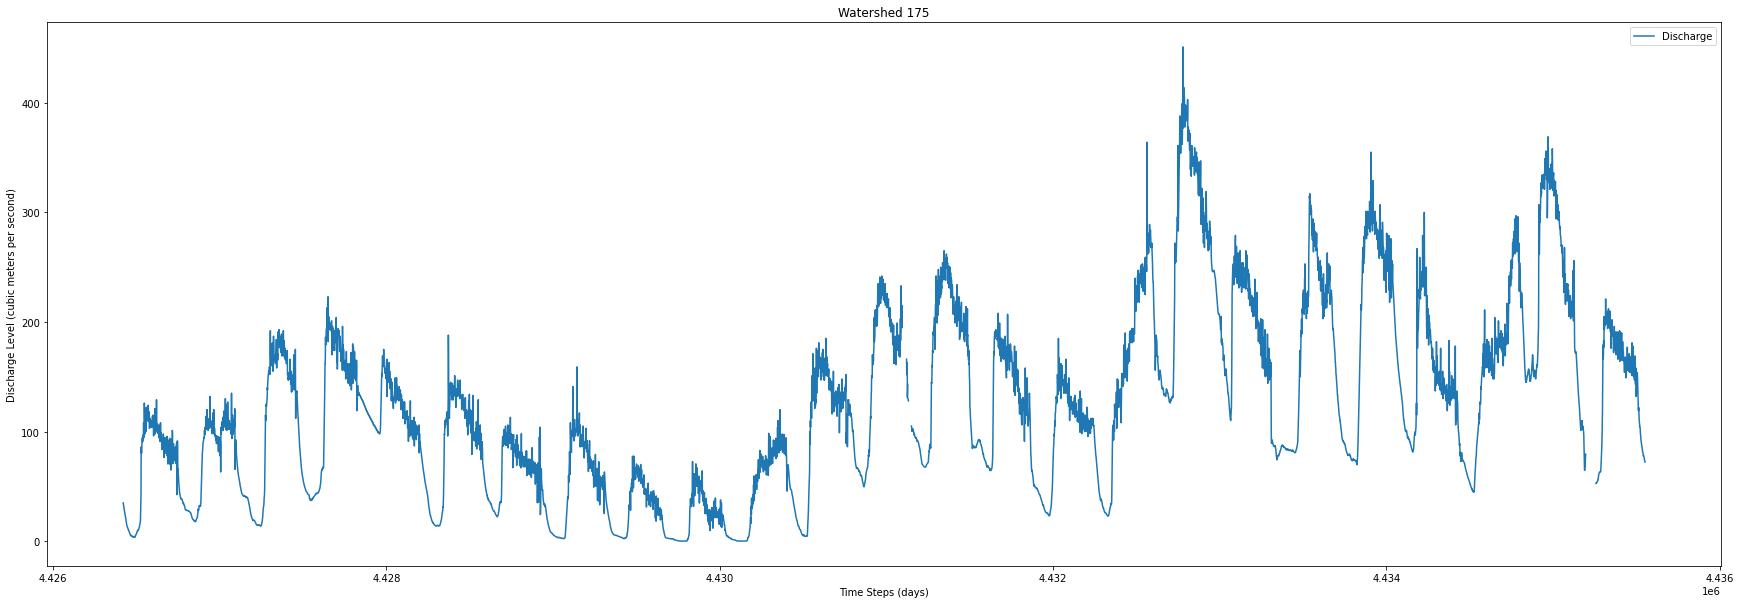

In [69]:
# For visual representation, plotting discharge of watershed 8

x = range(len(shed175))
y = shed175.discharge

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Watershed 175")
plt.xlabel("Time Steps (days forward from January 1, 1994)") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Discharge Level (cubic meters per second)")
plt.plot(y, label = 'Discharge')

plt.legend()
plt.show()

In [78]:
# For this watershed, the missing values do not acrue near peak discharge moments. 
# Using Pandas built in function 'interpolate', nan values will be filled in. 

# Switching the 'time' column to the datetime format.
shed175["time"] = pd.to_datetime(shed175["time"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [79]:
shed175.set_index('time', inplace = True)
for watershedID in set(shed175["watershed"]):
  shed175[shed175["watershed"] == watershedID] = shed175[shed175["watershed"] == watershedID].interpolate(method='time', axis=0, limit_direction="both")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1851: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


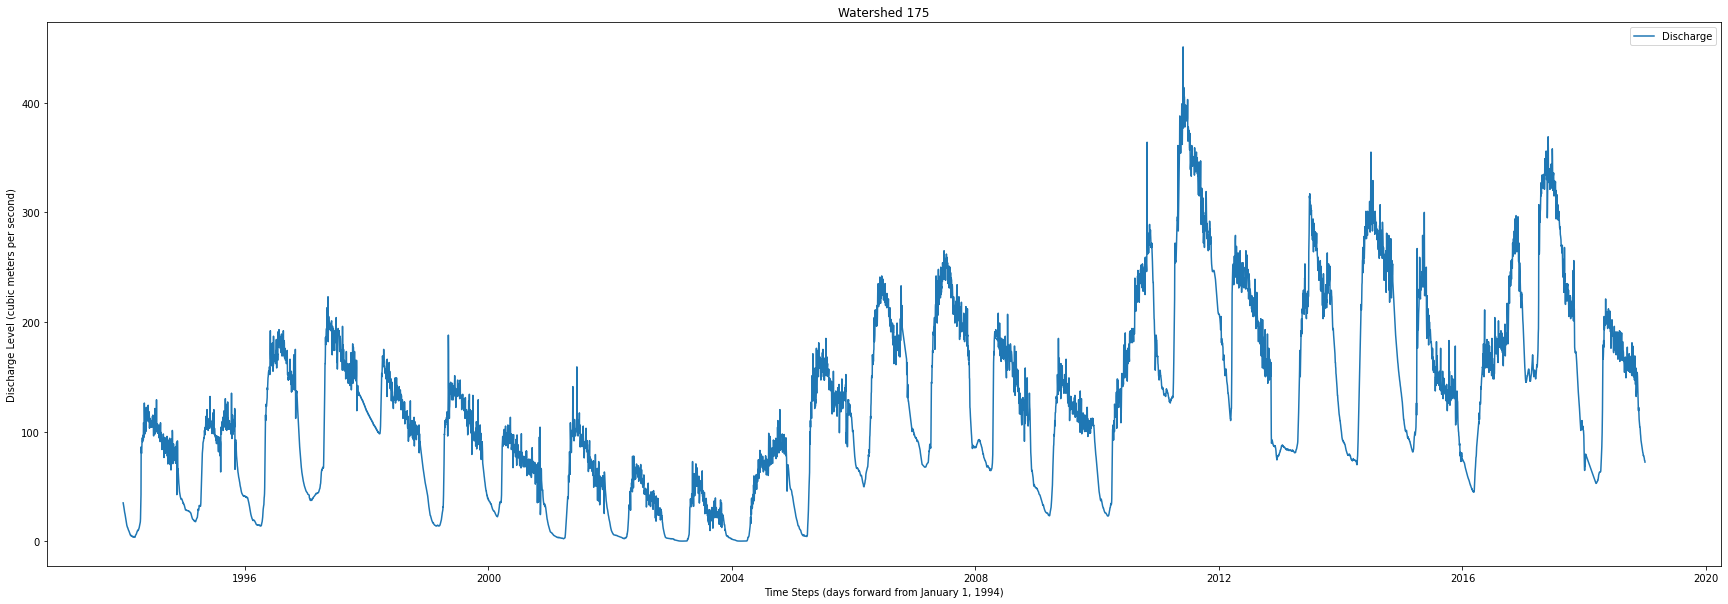

In [80]:
# For visual representation, plotting discharge of watershed 8

x = range(len(shed175))
y = shed175.discharge

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Watershed 175")
plt.xlabel("Time Steps (days forward from January 1, 1994)") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Discharge Level (cubic meters per second)")
plt.plot(y, label = 'Discharge')

plt.legend()
plt.show()

### Phase Three: Building the Multivariate Time Series Model


In [82]:
time_shift = 10

target_data = shed175['discharge'].shift(time_shift)
data = shed175.iloc[:-time_shift]
data

,watershed,pr,tasmax,tasmin,discharge
time,,,,,
1994-01-01,175,0.076526,-22.106535,-28.627773,34.9
1994-01-02,175,0.224076,-20.438263,-34.967842,33.8
1994-01-03,175,1.221324,-18.711952,-29.103697,33.1
1994-01-04,175,0.139639,-26.121840,-35.537575,32.2
1994-01-05,175,0.120722,-28.488220,-35.271194,31.4
...,...,...,...,...,...
2018-12-17,175,0.000000,-4.027343,-16.373430,80.7
2018-12-18,175,0.006535,1.261823,-8.819175,80.7
2018-12-19,175,0.000000,-1.919347,-7.985211,80.5


In [83]:
test_head = data.index[int(0.8*len(data))]
test_head

Timestamp('2013-12-23 00:00:00')

In [84]:
df_train = data.loc[:test_head,:]
df_test = data.loc[test_head:,:]
target_train = target_data.loc[:test_head]
target_test = target_data.loc[test_head:]

In [85]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [86]:
i = 27
sequence_length = 7
features = ['pr', 'discharge']
target = 'discharge'

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)

X, y = train_dataset[i]
print(X)

tensor([[ 0.7532, 14.9000],
        [ 0.1776, 14.4000],
        [ 0.0500, 13.9000],
        [ 1.5191, 13.5000],
        [ 0.1561, 12.9000],
        [ 1.5357, 12.4000],
        [ 0.1917, 12.3000]])


In [87]:
from torch.utils.data import DataLoader
torch.manual_seed(42)

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)

X, y = next(iter(train_loader))
print(X.shape)
print(X)

torch.Size([3, 7, 2])
tensor([[[2.7334e-01, 1.1500e+01],
         [1.0525e-01, 1.1200e+01],
         [0.0000e+00, 1.0700e+01],
         [0.0000e+00, 1.0600e+01],
         [2.9948e-01, 1.0300e+01],
         [1.2029e-01, 1.0200e+01],
         [6.7842e-02, 1.0200e+01]],

        [[7.7773e-01, 1.6000e+02],
         [2.0831e+00, 1.5100e+02],
         [5.9140e-01, 1.8800e+02],
         [3.3353e-01, 1.9300e+02],
         [6.3113e-02, 1.8300e+02],
         [6.0017e-02, 1.5000e+02],
         [4.2509e+00, 1.5300e+02]],

        [[1.0522e+00, 6.6500e+01],
         [0.0000e+00, 6.5300e+01],
         [1.2038e-03, 6.3600e+01],
         [2.1169e-01, 5.8000e+01],
         [8.4638e+00, 6.0300e+01],
         [4.3293e-01, 6.0400e+01],
         [6.4867e-01, 6.2100e+01]]])


In [88]:
batch_size = 4
sequence_length = 7

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([4, 7, 2])
Target shape: torch.Size([4])


In [89]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [90]:
learning_rate = 5e-4
num_hidden_units = 8

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [91]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(30):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()

Untrained test
--------
Test loss: 36083.4866304961

Epoch 0
---------
Train loss: 17340.629074305703
Test loss: 32672.6544055897

Epoch 1
---------
Train loss: 15548.209344963178
Test loss: 30236.94857060205

Epoch 2
---------
Train loss: 14154.761200089242
Test loss: 28008.241979753424

Epoch 3
---------
Train loss: 12893.172734350963
Test loss: 25916.312296026383

Epoch 4
---------
Train loss: 11748.981017824532
Test loss: 23949.182166068247

Epoch 5
---------
Train loss: 10661.402932209037
Test loss: 22108.43365739395

Epoch 6
---------
Train loss: 9685.093633316841
Test loss: 20378.78116847728

Epoch 7
---------
Train loss: 8763.939987236747
Test loss: 18757.624416543404

Epoch 8
---------
Train loss: 7941.587352603329
Test loss: 17262.522959018213

Epoch 9
---------
Train loss: 7211.594344592723
Test loss: 15874.492076485787

Epoch 10
---------
Train loss: 6518.691538487747
Test loss: 14579.62607364031

Epoch 11
---------
Train loss: 5903.672603108763
Test loss: 13379.70193105448

In [92]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

# for c in df_out.columns:
#     df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


            discharge  Model forecast
time                                 
1994-01-01       34.9       33.885941
1994-01-02       33.8       32.805023
1994-01-03       33.1       32.143517
1994-01-04       32.2       31.141642
1994-01-05       31.4       30.355021
...               ...             ...
2018-12-17       80.7       80.358521
2018-12-18       80.7       80.532600
2018-12-19       80.5       80.296127
2018-12-20       79.5       79.203293
2018-12-21       78.0       77.388237

[9122 rows x 2 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


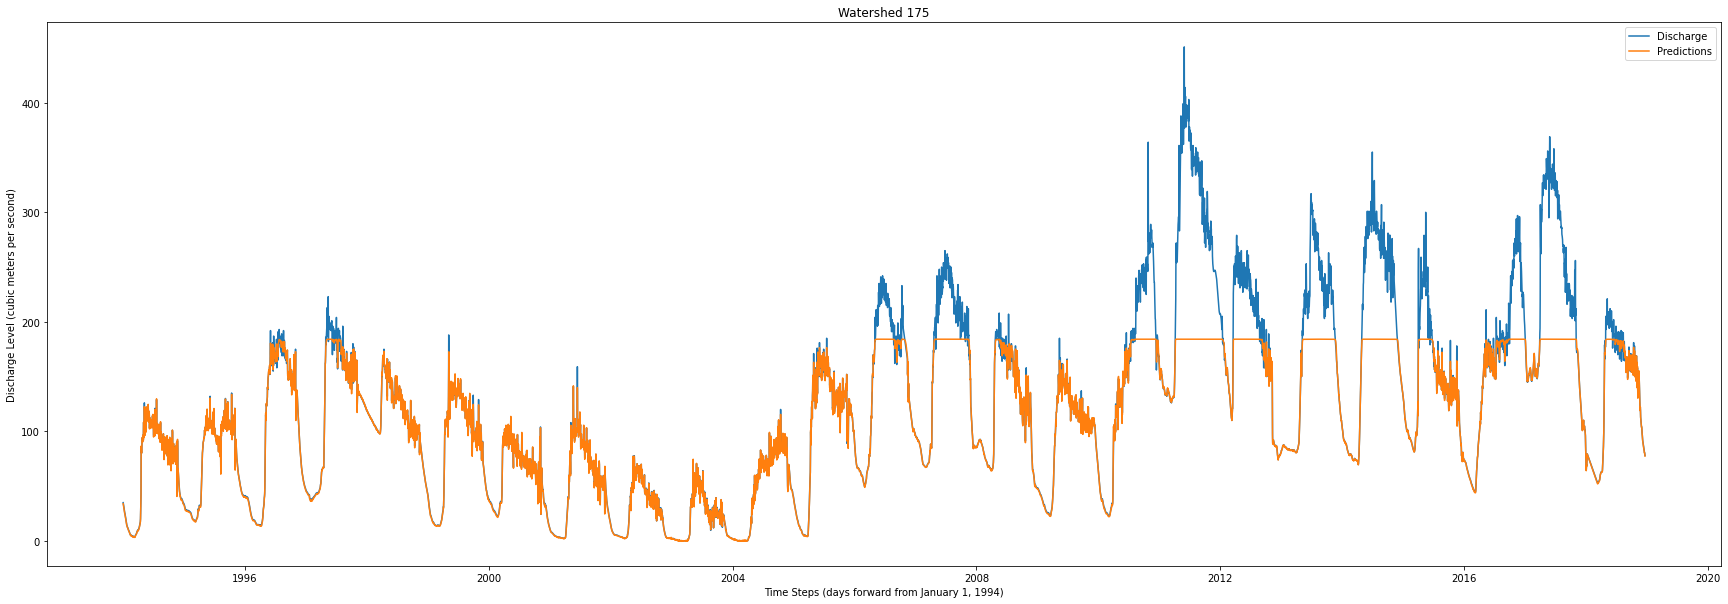

In [94]:
# For visual representation, plotting discharge of watershed 8

x = range(len(shed175))
y1 = df_out.discharge
y2 = df_out['Model forecast']

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Watershed 175")
plt.xlabel("Time Steps (days forward from January 1, 1994)") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Discharge Level (cubic meters per second)")
plt.plot(y1, label = 'Discharge')
plt.plot(y2, label = 'Predictions')

plt.legend()
plt.show()

In [97]:
# We are using SMAPE to measure the performance of our models. 
total = 0
for i in range(len(df_out)):
  predict = df_out['Model forecast'][i]
  recorded = df_out.discharge[i]
  top = np.abs(predict - recorded)
  bottom = ((predict + recorded)/2)
  answer = top/bottom
  total += answer
smape = total/len(df_out) * 100
print("For Watershed 175, this model's sMAPE score is:", smape)

For Watershed 175, this model's sMAPE score is: 6.645039474181269
